<a href="https://colab.research.google.com/github/Neuralnomad-hub/twitter-sentiment-vader-roberta/blob/main/code12nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

VADER-Based Sentiment Analysis on Tweets V/S Roberta based transformer from hugging face for sentiment analysis using NLP



1.first we are going to start with VADER-Based sentiment analysis

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

plt.style.use("ggplot")

In [ ]:
# Load the dataset
df = pd.read_csv("twitter_data_500.csv", header=None, names=["textID", "text"])
print(df.iloc[3:])

In [ ]:
nltk.download("vader_lexicon")

In [ ]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Analyze each tweet and store results
results = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['text']
    myid = row['textID']
    if isinstance(text, str):
        results[myid] = sia.polarity_scores(text)
    else:
        results[myid] = {"neg": 0, "neu": 0, "pos": 0, "compound": 0}

In [ ]:
# Convert the results to DataFrame
vader = pd.DataFrame(results).T
vader = vader.reset_index().rename(columns={"index": "textID"})
vader = vader.merge(df, on="textID", how="left")

# Labeling sentiment based on compound score
vader['Label'] = vader['compound'].apply(lambda c: 'positive' if c >= 0.05 else ('negative' if c <= -0.05 else 'neutral'))
output=vader.drop('textID', axis=1)
print(output)

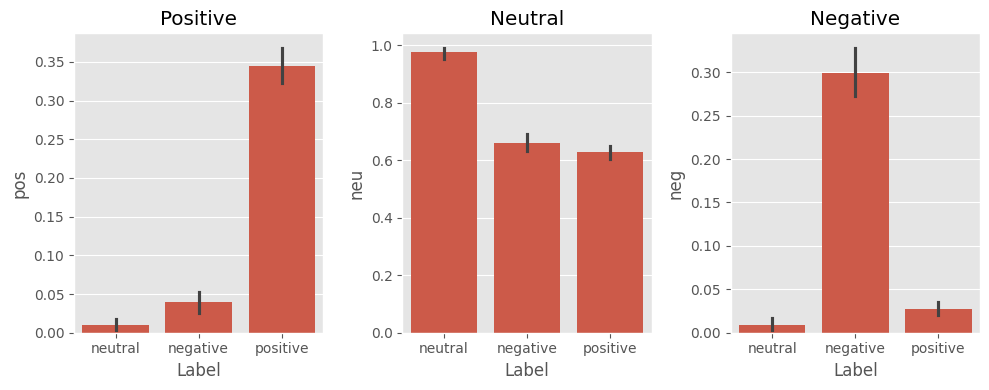

In [12]:
# Visualize sentiment distribution
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
sns.barplot(data=vader, x="Label", y="pos", ax=axs[0])
sns.barplot(data=vader, x="Label", y="neu", ax=axs[1])
sns.barplot(data=vader, x="Label", y="neg", ax=axs[2])

axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")
plt.tight_layout()
plt.show()


2.Now we gonna use Robverta Based transformer from Huggingface

In [ ]:
#roberta based tweet sentiment analysis
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [13]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
df1 = pd.read_csv("twitter_data_500.csv", header=None)
df1.columns = ['textID', 'text']
def polarity_scores_roberta(texts):
    neg = []
    neu = []
    pos = []
    for text in texts:
        if not isinstance(text, str) or text.strip() == "":
            neg.append(0)
            neu.append(0)
            pos.append(0)
            continue
        encoded = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            output = model(**encoded)
        scores = output.logits[0].numpy()
        scores = softmax(scores)
        neg.append(scores[0])
        neu.append(scores[1])
        pos.append(scores[2])
    return neg, neu, pos
neg, neu, pos = polarity_scores_roberta(df1["text"].tolist())
df1['roberta_neg'] = neg
df1['roberta_neu'] = neu
df1['roberta_pos'] = pos
# Display results, excluding the 'text' column
display(df1.drop('text', axis=1).head(10))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


,textID,roberta_neg,roberta_neu,roberta_pos
0,textID,0.254576,0.511313,0.234111
1,textID,0.254576,0.511313,0.234111
2,cb774db0d1,0.064939,0.808318,0.126744
3,549e992a42,0.918158,0.066100,0.015742
4,088c60f138,0.924613,0.070741,0.004646
5,9642c003ef,0.783082,0.192980,0.023938
6,358bd9e861,0.564197,0.404575,0.031229
7,28b57f3990,0.116091,0.404589,0.479320
8,6e0c6d75b1,0.001926,0.027040,0.971034
9,50e14c0bb8,0.063866,0.503986,0.432148


In [21]:
df1['roberta_Label'] = df1[['roberta_neg', 'roberta_neu', 'roberta_pos']].idxmax(axis=1).apply(lambda x: x.replace('roberta_', ''))
display(df1.drop('text', axis=1).head(10))

,textID,roberta_neg,roberta_neu,roberta_pos,roberta_Label
0,textID,0.254576,0.511313,0.234111,neu
1,textID,0.254576,0.511313,0.234111,neu
2,cb774db0d1,0.064939,0.808318,0.126744,neu
3,549e992a42,0.918158,0.066100,0.015742,neg
4,088c60f138,0.924613,0.070741,0.004646,neg
5,9642c003ef,0.783082,0.192980,0.023938,neg
6,358bd9e861,0.564197,0.404575,0.031229,neg
7,28b57f3990,0.116091,0.404589,0.479320,pos
8,6e0c6d75b1,0.001926,0.027040,0.971034,pos
9,50e14c0bb8,0.063866,0.503986,0.432148,neu


In [23]:
# Merge VADER and Roberta results
merged_df = pd.merge(vader, df1, on='textID', how='left')
comparison_crosstab = pd.crosstab(merged_df['Label'], merged_df['roberta_Label'])
display(comparison_crosstab)

roberta_Label,neg,neu,pos
Label,,,
negative,96,19,10
neutral,36,83,31
positive,30,48,150


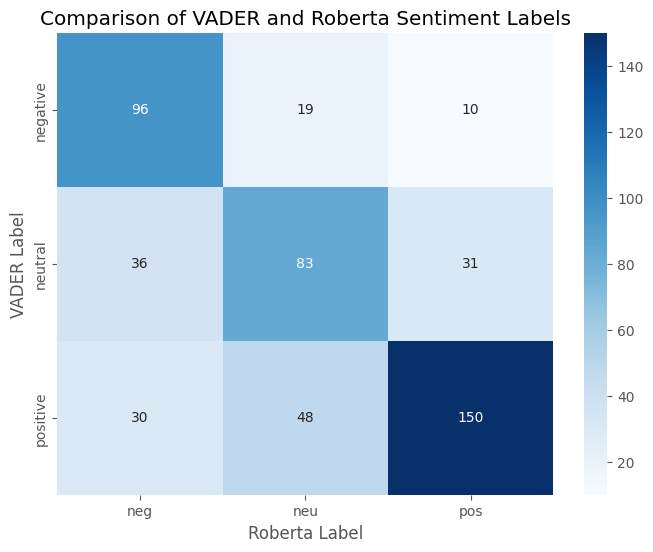

In [24]:
# Visualize the comparison using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(comparison_crosstab, annot=True, fmt='d', cmap='Blues')
plt.title('Comparison of VADER and Roberta Sentiment Labels')
plt.xlabel('Roberta Label')
plt.ylabel('VADER Label')
plt.show()